# KNN Model code

The code in this notebook file was used to create our KNN model and is sturctured like this: 

1. Data preperation and splitting the data
2. Training and evaluating the model
3. Visualizing correctly and incorrectly signs
4. RandomizedSearchCV cross-validation to find best parameters

## 1. Data preperation and splitting the data


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import time
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score


input_dir = r'C:\Users\benja\Directory\Bachelor\raadata_BS_H_N'


# Create empty lists to store the images and labels
original_images = []
data = []
labels = []
hog_images = []


# Loop over all the images in the input directory
for dirpath, dirnames, filenames in os.walk(input_dir):
    # Loop over the selected files in the directory
    for filename in filenames:
            image_path = os.path.join(dirpath, filename)
            img = cv2.imread(image_path)
            #original.append(img)
            img = cv2.resize(img, (32, 32))

            #lmfao_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
          
            # Perform L*A*B color space segmentation
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(img_lab)
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            l = clahe.apply(l)
            img_lab = cv2.merge((l,a,b))
            img_lab_seg = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)
            
            # Skin color detection
            lower_skin = np.array([0, 132, 80], dtype=np.uint8)
            upper_skin = np.array([255, 150, 170], dtype=np.uint8)
            mask = cv2.inRange(img_lab, lower_skin, upper_skin)
            img_skin = cv2.bitwise_and(img_lab, img_lab, mask=mask)
            
            # Merge the channels with the L channel
            img_lab_merge = cv2.merge([l, a, b])

            # Convert the LAB image back to RGB color space
            img_merge = cv2.cvtColor(img_lab_merge, cv2.COLOR_LAB2RGB)

            # Apply Canny edge detection to the foreground
            img_gray = cv2.cvtColor(img_merge, cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(img_gray, 100, 105)
            
            # Apply the skin color mask to the edge image
            edges = cv2.bitwise_and(edges, edges, mask=mask)

            hog_features, hog_image = hog(edges, orientations=15, pixels_per_cell=(6, 6), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

            
            #Display the images at different stages of processing
            # fig, axs = plt.subplots(1, 5, figsize=(15, 5))
        
            # axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            # axs[0].set_title('1.) Resized Image',fontsize=9)
            # axs[0].axis("off")

            # axs[1].imshow(cv2.cvtColor(img_lab_seg, cv2.COLOR_BGR2RGB))
            # axs[1].set_title('2.) L*A*B Color Space Segmentation',fontsize=9)
            # axs[1].axis("off")

            # axs[2].imshow(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))
            # axs[2].set_title('3.) Skin Color Detection',fontsize=9)
            # axs[2].axis("off")

            # axs[3].imshow(edges, cmap='gray')
            # axs[3].set_title('4.) Edge Detection',fontsize=9)
            # axs[3].axis("off")

            # axs[4].imshow(hog_image, cmap='gray')
            # axs[4].set_title('5.) HOG features', fontsize=9)
            # axs[4].axis("off")


            # plt.show()

            # Normalize the HOG features
            hog_features /= np.linalg.norm(hog_features)

            # Flatten the HOG features and add them to the data list
            data.append(hog_features.flatten())

            #adding original images and hog_images in order to visualise the results later
            original_images.append(img)
            hog_images.append(hog_image)

            # Add the label to the labels list
            labels.append(dirpath.split('\\')[-1])

# Convert the data and labels lists to numpy arrays
#original = np.array(original)
data = np.array(data)
labels = np.array(labels)

# Reshape the data to have the same number of features as the original images
#original = data.reshape(data.shape[0],-1)
data = data.reshape(data.shape[0], -1)

#we use indices to keep track of the data so we can visualise it easier when the model is finished training.
indices = np.arange(len(data))

#splitting the data into 70/30 training and test data. keeping track of the indices for later visualisation
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(data, labels, indices, test_size=0.3)




## 2. Training and evaluating the model


In [12]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# create KNN classifier object with specified hyperparameters
knn = KNeighborsClassifier(n_neighbors=4, weights='distance', metric='manhattan')

# fit KNN classifier to training data and measure time
start_time = time.time()
knn.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict the classes of the testing data and measure time
start_time = time.time()
y_pred = knn.predict(X_test)
prediction_time = time.time() - start_time


print(f"Training time: {training_time:.5f} seconds")
print(f"Prediction time: {prediction_time:.5f} seconds")
print(classification_report(y_test, y_pred))


Training time: 0.02300 seconds
Prediction time: 17.99599 seconds
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       289
          AE       0.99      0.99      0.99       230
           B       0.97      1.00      0.98       287
           C       0.99      0.99      0.99       281
           D       0.96      0.97      0.96       270
           E       1.00      0.91      0.95       293
           F       0.96      0.99      0.98       272
           G       0.99      0.99      0.99       276
           I       0.96      0.98      0.97       282
           J       0.99      0.97      0.98       258
           K       0.97      0.97      0.97       306
           L       0.96      0.93      0.95       253
           M       0.92      0.96      0.94       264
           N       0.97      0.95      0.96       266
           O       0.97      0.94      0.96       289
          OE       1.00      1.00      1.00       259
           P    

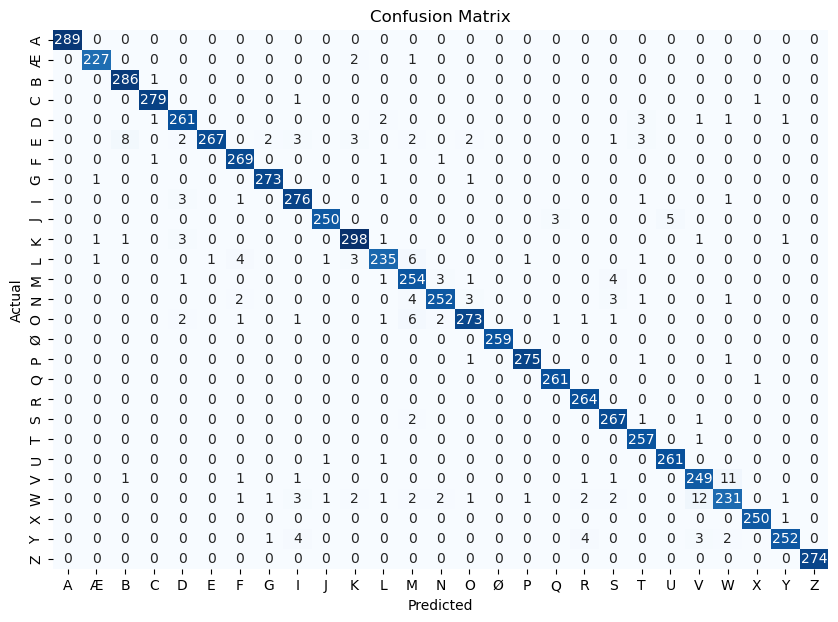

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the labels for the classes
class_names = ['A','Æ', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'J', 'K', 'L', 'M',
               'N', 'O','Ø', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',]

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
#save the model

import pickle

with open("32x32_knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)

## 3. Visualizing correctly and incorrectly signs


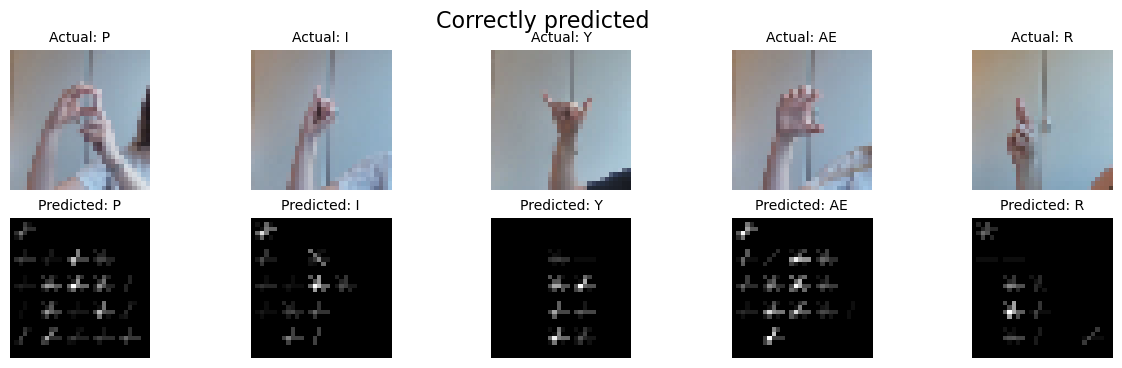

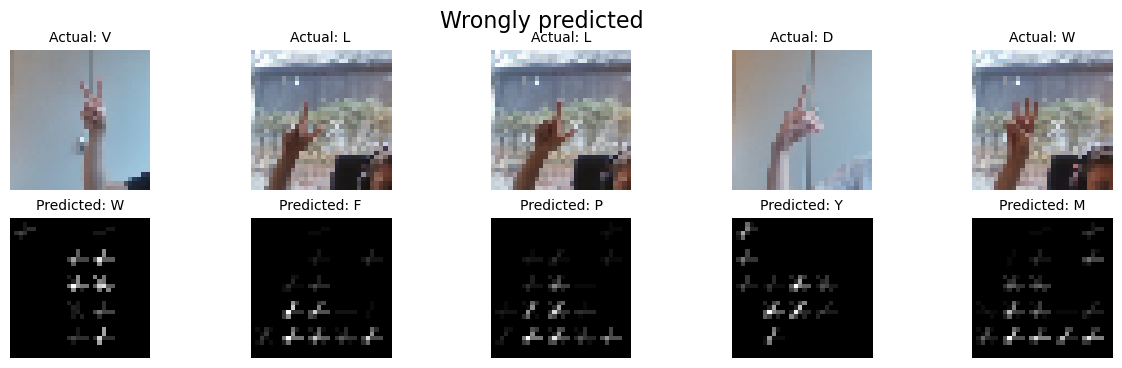

In [15]:
# get the indices of the correctly and incorrectly predicted samples
correct_idx = np.where(y_test == y_pred)[0]
incorrect_idx = np.where(y_test != y_pred)[0]

# choose 10 random instances from each set of indices
correct_samples = np.random.choice(correct_idx, size=5, replace=False)
if len(incorrect_idx) >= 5:
    incorrect_samples = np.random.choice(incorrect_idx, size=5, replace=False)
else:
    incorrect_samples = np.random.choice(incorrect_idx, size=len(incorrect_idx), replace=False)


# Display the 5 correctly predicted samples
fig, axes = plt.subplots(2, 5, figsize=(15, 4))
fig.suptitle('Correctly predicted', fontsize=16)

for i, idx in enumerate(correct_samples):
    orig_img = original_images[test_indices[idx]]
    orig_label = y_test[idx]
    hog_img = hog_images[test_indices[idx]]
    
    axes[0, i].imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f'Actual: {orig_label}', fontsize=10)
    axes[0, i].axis('off')

    axes[1, i].imshow(hog_img, cmap='gray')
    axes[1, i].set_title(f'Predicted: {y_pred[idx]}', fontsize=10)
    axes[1, i].axis('off')

# Display the 5 wrongly predicted samples
fig, axes = plt.subplots(2, 5, figsize=(15, 4))
fig.suptitle('Wrongly predicted', fontsize=16)

for i, idx in enumerate(incorrect_samples):
    orig_img = original_images[test_indices[idx]]
    orig_label = y_test[idx]
    hog_img = hog_images[test_indices[idx]]

    axes[0, i].imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
    axes[0,i].set_title(f'Actual: {orig_label}', fontsize=10)
    axes[0,i].axis('off')

    axes[1,i].imshow(hog_img, cmap='gray')
    axes[1,i].set_title(f'Predicted: {y_pred[idx]}', fontsize=10)
    axes[1,i].axis('off')

plt.show()


## 4. RandomizedSearchCV cross-validation to find best parameters

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter grid
param_dist = {'n_neighbors': randint(1, 100),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'minkowski']}

# Create the KNN model
KNN_model = KNeighborsClassifier()

# Perform a randomized search with cross-validation
rand_search = RandomizedSearchCV(KNN_model, param_distributions=param_dist, n_iter=50,
                                 cv=10, random_state=42, scoring='accuracy', n_jobs=-1)

# Fit the randomized search to the training data
rand_search.fit(X_train, y_train)

# Get the best parameters and the corresponding accuracy score 
best_params = rand_search.best_params_
best_score = rand_search.best_score_

# Print the best parameters and the corresponding accuracy score
print("Best parameters: ", best_params)
print("Best accuracy score: ", best_score)

# Visualize the best weights and metric
fig, ax = plt.subplots(figsize=(8,6))
plt.bar(x=range(len(KNN_model.weights)), height=KNN_model.weights, tick_label=KNN_model.metric)
plt.title("Best Weights and Metric")
plt.xlabel("Metric")
plt.ylabel("Weight")
plt.show()